In [1]:
import tensorflow.compat.v1 as tf
import pandas as pd
import seaborn as sns
import scipy.io
import numpy as np
import os
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import hdf5storage

In [2]:
def fnn(x, input_size, output_size, keep_prob, stddev=0.01, constant=0.0001, dropout=True, end=False):
    fc_w = tf.Variable(tf.truncated_normal([input_size,output_size], stddev=stddev,seed=np.random.seed(2018)))
    fc_b = tf.Variable(tf.constant(constant,shape=[output_size]), dtype=tf.float32)
    fc_h = tf.nn.relu(tf.matmul(x,fc_w)+fc_b) if not end else tf.matmul(x,fc_w)+fc_b
    return tf.nn.dropout(fc_h, keep_prob,seed=np.random.seed(2018)) if dropout else fc_h

In [3]:
def fcn(x, input_size, output_size, nlayers, nparameters, keep_prob):
    if nlayers == 1:
        h1 = fnn(x, input_size, output_size, keep_prob, end=True)
    elif nlayers == 2:
        h1 = fnn(fnn(x, input_size, nparameters, keep_prob, end=False), nparameters, output_size, keep_prob, end=True)
    elif nlayers >= 3:
        h0 = fnn(x, input_size, nparameters, keep_prob, end=False)
        for j in range(0,nlayers-2):
            if j == 0:
                h1 = fnn(h0, nparameters, nparameters, keep_prob, end=False)
            else:
                h1 = fnn(h1, nparameters, nparameters, keep_prob, end=False)
        h1 = fnn(h1, nparameters, output_size, keep_prob, end=True)
    else:
        print("# of layers can't be smaller than 0")
    return h1

In [4]:
def rfc(train_data, train_label, test_data, test_label):
    rf = RandomForestClassifier(n_estimators=150,
                                    criterion='gini',
                                    max_depth=None,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    max_leaf_nodes=None,
                                    bootstrap=True,
                                    oob_score=False,
                                    n_jobs=10,
                                    random_state=123,
                                    verbose=0,
                                    warm_start=False,
                                    class_weight=None)
    rf.fit(train_data, train_label.ravel())
    result = rf.predict_proba(test_data)
    acc = 0.0
    for i in range(np.shape(test_data)[0]):
        r = np.argmax(result[i])
        if r == test_label[i]:
            acc += 1
    acc /= np.shape(test_data)[0]
    acc *= 100
    return acc, result

In [5]:
def dnn(train_data, train_label, test_data, test_label):
    g = tf.Graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    batch_size = 10
    input_size = np.shape(train_data)[1]
    output_size = 31

    with g.as_default():
        p_x = tf.placeholder(tf.float32, [batch_size, 1, input_size, 1])
        p_y = tf.placeholder(tf.float32, [batch_size, output_size])
        keep_prob = tf.placeholder(tf.float32)
        h10_flat = tf.reshape(p_x, [batch_size,-1])
        h1 = fnn(h10_flat, input_size, 2048, keep_prob, end=False)
        h2 = fnn(h1, 2048, 2048, keep_prob, end=False)
        h3 = fnn(h2, 2048, 31, keep_prob, end=True)
        h4 = tf.reshape(h3, [batch_size, 31])
        h_c = tf.nn.softmax(h4)
        loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=p_y, logits=h4))
        optim = tf.train.AdamOptimizer(1e-5)
        trainer = optim.minimize(loss)
    
    accuracy = 0.0
    result = np.zeros([np.shape(test_data)[0], 31])
    with tf.Session(graph=g, config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(0,120):
            loss_tot = 0.0
            for i in range(0,int(np.ceil(np.shape(train_data)[0]/batch_size))):
                a = np.random.randint(0,np.shape(train_data)[0],size=batch_size)
                x = train_data[a].reshape([batch_size, 1, input_size, 1])#[4,1,18181,1]
                y = np.zeros([batch_size, output_size])
                index = train_label[a]
                for u in range(0,batch_size):
                    y[u,index[u]] = 1
                _ , loss_val = sess.run([trainer, loss], feed_dict={p_x:x, p_y:y, keep_prob:0.6})
                loss_tot += loss_val
            #print("%d epoch Loss: %f" % (e,(loss_tot)/np.shape(train_data)[0]))
        temp = 0
        for i in range(0,int(np.floor(np.shape(test_data)[0]/batch_size))):
            x = test_data[i*batch_size:(i+1)*batch_size].reshape([batch_size, 1, input_size, 1])
            out = sess.run(h_c, feed_dict={p_x:x, keep_prob:1})
            for j in range(0, batch_size):
                t = np.squeeze(out[j])
                result[temp] = t
                temp+=1
        remain = int(np.shape(test_data)[0]-np.floor(np.shape(test_data)[0]/batch_size)*batch_size)
        if remain > 0:
            x = test_data[-batch_size-1:-1].reshape([batch_size, 1, input_size, 1])
            out = sess.run(h_c, feed_dict={p_x:x, keep_prob:1})
            for j in range(0,int(remain)):
                t = np.squeeze(out[j+(batch_size-remain)])
                result[temp] = t
                temp+=1
        for i in range(0,np.shape(test_data)[0]):
            ind = np.argmax(np.squeeze(result[i]))
            if ind == test_label[i]:
                accuracy += 1
        accuracy /= np.shape(test_data)[0]*0.01
        sess.close()
    return accuracy, result

In [6]:
dataID = hdf5storage.loadmat('data.mat')
data = np.array(dataID['data'], dtype=np.float32)
gt1 = scipy.io.loadmat('label.mat')
label = np.array(gt1['label'], dtype=np.int32)

In [7]:
Outer_loop = 10
Inner_loop = 10

In [8]:
if __name__ == "__main__":
#Load data

    
    #Initialize
    label -= 1
    np.random.seed(2018)


    
    t_index = np.random.permutation(int(np.shape(data)[0]/Outer_loop)*Outer_loop)
    t_index = np.reshape(t_index, [Outer_loop, -1])
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    box = np.array([500, 1000, 4000, 8000, 35565], dtype=np.int32)
    flag = 0
    for test_index in t_index:
        if flag == Outer_loop-1:
            test_index = np.array(np.concatenate((test_index, np.array(range(int(np.shape(data)[0]/Outer_loop)*Outer_loop,np.shape(data)[0]))), axis=0), dtype=np.int32)
        train_index = np.setdiff1d(np.array(range(0,np.shape(data)[0])), test_index)
        train_data = data[train_index]
        train_label = label[train_index]
        test_data = data[test_index]
        test_label = label[test_index]
        
        kf = np.random.permutation(int(np.shape(train_data)[0]/Inner_loop)*Inner_loop)
        kf = kf.reshape([Inner_loop]+[-1])
        val_result = np.zeros([np.shape(train_data)[0],48], dtype=np.float32)
        
        tot_acc = np.zeros([Inner_loop,5], dtype=np.float32)
        lsvc = LinearSVC(C=1, penalty="l1", dual=False).fit(data, label)
        coef = np.squeeze(np.sum(np.square(np.array(lsvc.coef_)), axis=0))
        coefidx = np.argsort(coef)
        for inner_fold in range(0,Inner_loop):
            val_test_ind = kf[inner_fold]
            if inner_fold == Inner_loop-1:
                val_test_ind = np.array(np.concatenate((val_test_ind,np.array(range(int(np.shape(train_data)[0]/Outer_loop)*Outer_loop,np.shape(train_data)[0]),dtype=np.int32)), axis=0),dtype=np.int32)
            
            val_train_ind = np.setdiff1d(np.array(range(0,np.shape(train_data)[0]),dtype=np.int32), val_test_ind)
            val_train = train_data[val_train_ind]
            val_test = train_data[val_test_ind]
            val_train_label = train_label[val_train_ind]
            val_test_label = train_label[val_test_ind]
            temp = 0
            for item in box:
                idx = coefidx[-item:]
                vtrain = val_train[:,idx]
                vtest = val_test[:,idx]
                nn_acc, result_nn = dnn(vtrain, val_train_label, vtest, val_test_label)
                rf_acc, result_rf = rfc(vtrain, val_train_label, vtest, val_test_label)
                en_acc = 0.0
                for i in range(0,np.shape(vtest)[0]):
                    r = np.argmax(result_nn[i]+result_rf[i])
                    if r == val_test_label[i]:
                        en_acc += 1
                en_acc /= np.shape(vtest)[0]*0.01
                tot_acc[inner_fold,temp] = en_acc
                print("Inner_fold # of features: %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (item, nn_acc, rf_acc, en_acc))
                temp += 1
        
        u = np.sum(tot_acc,0)
       
        best_n = box[np.argmax(u)]
        idx = coefidx[-best_n:]
        
        tr_data = train_data[:,idx]
        te_data = test_data[:,idx]
        nn_acc, result_nn = dnn(tr_data, train_label, te_data, test_label)
        rf_acc, result_rf = rfc(tr_data, train_label, te_data, test_label)
        en_acc = 0.0
        for i in range(0,np.shape(te_data)[0]):
            r = np.argmax(result_nn[i]+result_rf[i])
            if r == test_label[i]:
                en_acc += 1
        en_acc /= np.shape(te_data)[0]*0.01
        print("Outer_fold # of features:  %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (best_n, nn_acc, rf_acc, en_acc))
        flag += 1

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Inner_fold # of features: 500, Neural network accuracy: 77.777778, Random forests accuracy: 70.793651, Ensemble accuracy: 78.412698
Inner_fold # of features: 1000, Neural network accuracy: 81.111111, Random forests accuracy: 71.269841, Ensemble accuracy: 81.904762
Inner_fold # of features: 4000, Neural network accuracy: 81.904762, Random forests accuracy: 70.952381, Ensemble accuracy: 83.492063
Inner_fold # of features: 8000, Neural network accuracy: 80.952381, Random forests accuracy: 71.111111, Ensemble accuracy: 81.587302
Inner_fold # of features: 35565, Neural network accuracy: 76.825397, Random forest

KeyboardInterrupt: 

In [ ]:
# NN_500=[78.095238,78.412698,79.365079,80.317460,80.476190,73.333333,77.301587,79.841270,80.158730,75.000000]
# RF_500=[70.793651,73.492063,74.126984,73.333333,73.492063,71.269841,72.539683,71.111111,72.380952,71.518987]
# emsemble_500=[79.047619,81.269841,82.539683,83.968254,83.968254,78.095238,80.634921,82.539683,83.174603,78.955696]

In [ ]:
# NN_1000=[79.841270,81.746032,84.126984,82.539683,83.174603,77.936508,80.793651,83.650794,81.746032,81.803797]
# RF_1000=[71.269841,74.603175,73.492063,74.126984,73.650794,71.746032,72.222222,71.428571,74.285714,71.518987]
# emsemble_1000=[81.269841,84.126984,86.507937,85.714286,85.396825,80.476190,83.809524,84.126984,84.285714,82.753165]

In [ ]:
# NN_4000=[81.587302,84.444444,84.285714,85.873016,85.555556,81.587302,85.714286,84.920635,85.079365,85.126582]
# RF_4000=[70.952381,73.333333,73.968254,75.714286,72.539683,72.539683,73.015873,72.539683,74.444444,71.202532]
# emsemble_4000=[83.492063,85.873016,85.238095,86.666667,86.031746,83.333333,86.666667,86.825397,86.507937,87.025316]

In [ ]:
# NN_8000=[80.952381,81.269841,83.174603,83.968254,83.968254,80.634921,81.587302,84.920635,84.761905,82.753165]
# RF_8000=[71.111111,73.174603,73.492063,75.396825,72.063492,71.269841,72.857143,71.587302,73.650794,71.202532]
# emsemble_8000=[82.857143,83.174603,84.761905,85.714286,85.079365,82.222222,84.126984,85.873016,86.190476,83.702532]

In [ ]:
# NN_35565=[75.555556,74.761905,78.730159,80.158730,77.301587,74.920635,78.095238,78.571429,76.984127,75.316456]
# RF_35565=[70.634921,72.222222,73.333333,74.761905,73.492063,73.174603,73.333333,71.904762,73.809524,72.468354]
# emsemble_35565=[77.619048,78.571429,82.222222,82.539683,81.269841,77.301587,79.206349,80.793651,79.047619,77.848101]

In [9]:
MD_acc=[79.047619,81.269841,82.539683,83.968254,83.968254,78.095238,80.634921,82.539683,83.174603,78.955696,#500
       78.095238,78.412698,79.365079,80.317460,80.476190,73.333333,77.301587,79.841270,80.158730,75.000000,
       70.793651,73.492063,74.126984,73.333333,73.492063,71.269841,72.539683,71.111111,72.380952,71.518987,
       81.269841,84.126984,86.507937,85.714286,85.396825,80.476190,83.809524,84.126984,84.285714,82.753165,#1000
       79.841270,81.746032,84.126984,82.539683,83.174603,77.936508,80.793651,83.650794,81.746032,81.803797,
       71.269841,74.603175,73.492063,74.126984,73.650794,71.746032,72.222222,71.428571,74.285714,71.518987,
       83.492063,85.873016,85.238095,86.666667,86.031746,83.333333,86.666667,86.825397,86.507937,87.025316,#4000
       81.587302,84.444444,84.285714,85.873016,85.555556,81.587302,85.714286,84.920635,85.079365,85.126582,
       70.952381,73.333333,73.968254,75.714286,72.539683,72.539683,73.015873,72.539683,74.444444,71.202532,
       82.857143,83.174603,84.761905,85.714286,85.079365,82.222222,84.126984,85.873016,86.190476,83.702532,#8000
       80.952381,81.269841,83.174603,83.968254,83.968254,80.634921,81.587302,84.920635,84.761905,82.753165,
       71.111111,73.174603,73.492063,75.396825,72.063492,71.269841,72.857143,71.587302,73.650794,71.202532,
       77.619048,78.571429,82.222222,82.539683,81.269841,77.301587,79.206349,80.793651,79.047619,77.848101,#35565
       75.555556,74.761905,78.730159,80.158730,77.301587,74.920635,78.095238,78.571429,76.984127,75.316456,
       70.634921,72.222222,73.333333,74.761905,73.492063,73.174603,73.333333,71.904762,73.809524,72.468354,
       ]
MD_num=[500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,
       1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,
       4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,
       8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,
       35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565,35565]
MD_md=['ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble',
       'neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network',
       'random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest',
       'ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble',
       'neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network',
       'random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest',
       'ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble',
       'neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network',
       'random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest',
       'ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble',
       'neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network',
       'random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest',
       'ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble',
       'neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network',
       'random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest',
       
       ]

In [10]:
data = {'Accuracy':MD_acc,'Feature Number':MD_num, 'Model':MD_md}

In [11]:
df = pd.DataFrame(data)
df

,Accuracy,Feature Number,Model
0,79.047619,500,ensemble
1,81.269841,500,ensemble
2,82.539683,500,ensemble
3,83.968254,500,ensemble
4,83.968254,500,ensemble
...,...,...,...
145,73.174603,35565,random forest
146,73.333333,35565,random forest
147,71.904762,35565,random forest
148,73.809524,35565,random forest


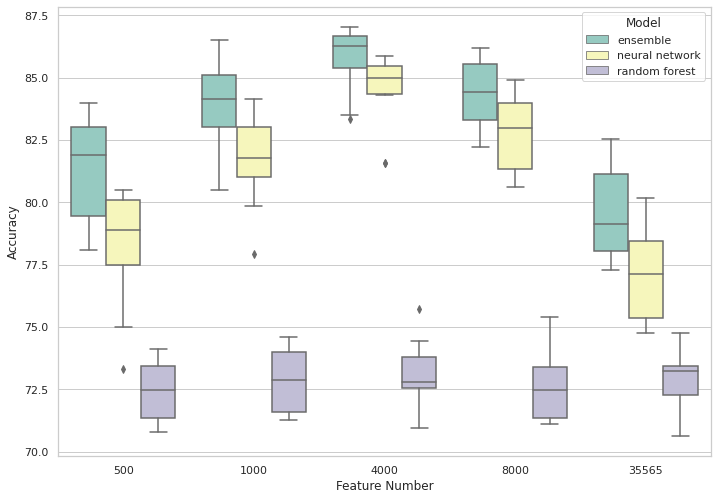

In [12]:
sns.set(style="whitegrid",rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
ax = sns.boxplot(x = "Feature Number", y = "Accuracy", hue="Model", data = df, palette = "Set3")